## 回归话题补充
两种不同的训练模型的方式
- 通过闭式方程，直接计算出最拟合训练集的模型参数
- 迭代优化的方式：梯度下降和它的变体：批量梯度下降，小批量梯度下降以及随机梯度下降

多种正则化技巧
- 岭回归，Lasso回归和弹性网络回归

分类任务模型
- 针对多分类的softmax回归  （通过组合二元分类做多分类，直接做多分类）

### 闭式方程
$$
\hat{\theta} = (X^\top X)^{-1} X^\top y
$$

这个方程中：

- $\hat{\theta}$ 是使代价函数最小的 $\theta$ 值。
- $y$ 是包含 $y^{(1)}$ 到 $y^{(m)}$ 的目标值向量。


In [2]:
# 生成假数据
import numpy as np

np.random.seed(100)

m = 100
X = 2 * np.random.rand(m, 1)

y = 4 + 3 * X + np.random.randn(m, 1)   # y = 4+3*x + 随机数

In [5]:
# 用方程拟合
from sklearn.preprocessing import add_dummy_feature

# 如果想通过 方程，直接把最有的 截距b 算出来，直接往 特征矩阵里面 加一列1 就可以

X_b = add_dummy_feature(X)  # X里 增加一列1
# print(X)
# print(X_b)
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best

array([[3.98485975],
       [2.86232606]])

In [6]:
# 做出预测
X_new = np.array([[0],
                  [2]])
X_new_b = add_dummy_feature(X_new) # X_new里 增加一列1
y_predict = X_new_b @ theta_best
y_predict

array([[3.98485975],
       [9.70951187]])

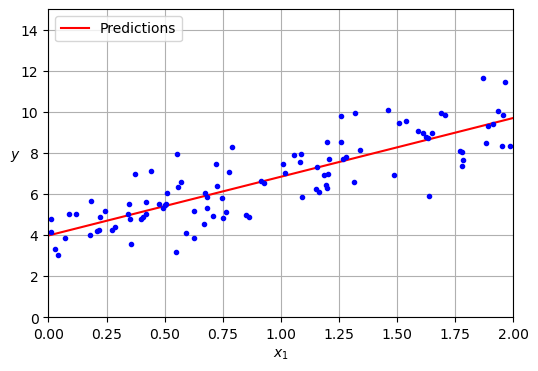

In [7]:
# 绘制预测结果
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
# plt.plot(X_new, y_predict, "r-", label="Predictions")  # c="r", linestyle="-"
plt.plot(X_new, y_predict, label="Predictions", c="r", linestyle="-")
plt.plot(X, y, c="b",  marker=".", linestyle="")  # plt.plot(X, y, "b.")  用画折线图的方式 画散点图

# extra code – beautifies and saves Figure 4–2
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

In [8]:
# 使用sklearn做更简单了


from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)  #  线性回归内部 它用的是方程 ，算最优参数
lin_reg.intercept_, lin_reg.coef_
lin_reg.predict(X_new)

array([[3.98485975],
       [9.70951187]])

In [9]:
# LinearRegression类基于 np.linalg.lstsq()函数，可以直接调用它
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.98485975],
       [2.86232606]])

In [10]:
# 上面的函数计算的是 X的伪逆(np.linalg.pinv(), Moore-Penrose逆） 和 y的矩阵乘法
np.linalg.pinv(X_b) @ y

array([[3.98485975],
       [2.86232606]])

伪逆本身是使用被称为奇异值分解(Singular Value Decomposition，SVD)的标准矩阵分解技术来计算的，可以分解训练集矩阵X为三个矩阵UΣV⊤的乘积［numpy.linalg.svd()］。伪逆的计算公式为：X+=VΣ+U⊤。为了计算矩阵Σ+，该算法取Σ并将所有小于一个小阈值的值设置为零，然后将所有非零值替换成它们的倒数，最后把结果矩阵转置。这种方法比计算标准方程更有效，而且它可以很好地处理边缘情况：的确，标准方程可能没有解，如果矩阵X⊤X是不可逆的（即奇异的），例如如果m＜n或某些特征是多余的，但伪逆总是有定义的。

#### 计算复杂度
标准方程计算$X^⊤X$的逆，是一个(n+1)×(n+1)的矩阵（n是特征数量）。对这种矩阵求逆的计算复杂度通常为O(n^2.4)到O(n^3)之间，取决于具体实现。换句话说，如果将特征数量翻倍，那么计算时间将乘以大约2^2.4=5.3倍到2^3=8倍。Scikit-Learn的LinearRegression类使用的SVD方法复杂度约为O(n^2)。如果你将特征数量加倍，那计算时间大约是原来的4倍。

特征数量比较大（例如100000）时，标准方程和SVD的计算将极其缓慢。好的一面是，相对于训练集中的实例数量[O(m)]来说，两个都是线性的，所以能够有效地处理大量的训练集，只要内存足够。同样，线性回归模型一经训练（不论是标准方程还是其他算法）​，预测就非常快速：因为计算复杂度相对于想要预测的实例数量和特征数量来说，都是线性的。换句话说，对两倍的实例（或者是两倍的特征）进行预测，大概需要两倍的时间。

### 梯度下降
- 更适合特征数量或者训练实例数量大到内存无法满足要求的场景。

- 要点复习：不同尺度的特征梯度下降速度不一样，应用梯度下降时，需要保证所有特征值的大小比例都差不多（Sklearn的StandardScaler类），否则收敛的时间会长很多
![有和没有特征缩放的梯度下降](./images/regression/p1.png)

左边的训练集特征1和特征2有相同的数值规模，而右边的训练集上，特征1的值比特征2要小得多。（因为特征1较小，需要比特征2有更大的变化才能影响代价函数，这也是被拉长的特征是更小的特征的原因）

In [11]:
# 批量梯度下降算法快速实现
# 批量梯度下降： 每个轮次 都在拿所有训练集 计算梯度
eta = 0.1 # 学习率
n_epochs = 1000   # 轮次
m = len(X_b)

np.random.seed(100)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    gradients = X_b.T @ (X_b @ theta - y) / m
    theta = theta - eta * gradients


In [12]:
theta

array([[3.9848596],
       [2.8623262]])

#### 随机梯度下降(Stochastic Gradient Descent)


批量梯度下降的主要问题是它要用整个训练集来计算每一步的梯度，所以当训练集很大时，算法会特别慢。与之相反的极端是随机梯度下降，随机梯度下降每一步在训练集中随机选择一个实例，并且仅基于该单个实例来计算梯度。显然，这让算法变得快多了，因为每个迭代都只需要操作少量的数据。它也可以被用来训练海量的数据集，因为每次迭代只需要在内存中运行一个实例（SGD可以作为核外算法实现，大量数据无法一次载入内存，分批训练）。另外，由于算法的随机性质，它比批量梯度下降要不规则得多。代价函数将不再是缓缓降低直到抵达最小值，而是不断上上下下，但是从整体来看，还是在慢慢下降。随着时间推移，代价函数最终会非常接近最小值，但是即使它到达了最小值，依旧会持续反弹，永远不会停止。一旦算法停止，最终的参数值会很好，但不是最优的。

![随机梯度下降的路线图](./images/regression/p2.png)

当代价函数非常不规则时，随机梯度下降其实可以帮助算法跳出局部最小值，所以相比批量梯度下降，它对找到全局最小值更有优势。因此，随机性的好处在于可以逃离局部最优，但缺点是永远定位不出最小值。

要解决这个困境，有一个办法是逐步降低学习率。开始的步长比较大（这有助于快速进展和逃离局部最小值），然后越来越小，让算法尽量靠近全局最小值。这个过程叫作模拟退火，因为它类似于冶金时熔化的金属慢慢冷却的退火过程。确定每个迭代学习率的函数叫作学习率调度。如果学习率降得太快，可能会陷入局部最小值，甚至停留在走向最小值的半途中。如果学习率降得太慢，你需要很长时间才能跳到最小值附近，如果提早结束训练，可能只得到一个次优的解决方案。

学习率调度理解：t（迭代次数） -> 学习率，eta = 1.0 / (alpha * (t + t0))； t0和alpha两个超参数， 一个用来确定初始学习率，一个用来确定学习率衰减速度，要提前确定； 或者是 按 eta = eta0 / (1+k*t)理解, eta0是初始学习率，k是衰减的速度

In [17]:
# 有学习率调度的随机梯度下降实现

n_epochs = 500
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)  # 5 / (50+t) -> 0.1 / (1 + 0.02t)  # t 增加， 这里返回值在降低，降低的速度是0.02

np.random.seed(100)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):   # 轮次
    # 这里可以去随机打乱训练集，下面按索引顺序去取样本，既保证随机，又保证下面每个样本被取到了

    for iteration in range(m):  # 每个轮次，都在遍历所有的样本（执行样本数量次数）

        # 下面三行在随机抽取样本（特征 + 标签）
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]

        gradients = xi.T @ (xi @ theta - yi)  # 单个样本的梯度 不需要除以m
        eta = learning_schedule(epoch*m + iteration)  # 当前迭代次数： t = 当前轮次 * 样本数量 + 现在的迭代次数  -> 根据学习率调度函数，调出现在的学习率
        theta = theta - eta * gradients


In [18]:
# 3.89, 2.87
theta

array([[3.95910888],
       [2.88059611]])

用随机梯度下降时，训练实例必须独立且在同一个概率分布下(Independent and Identically Distributed，IID)，以确保平均而言将参数拉向全局最优值。确保这一点的一种简单方法是在训练过程中对实例进行随机混洗（例如，随机选择每个实例，或者在每个轮次开始时随机混洗训练集）。如果不对实例进行混洗（例如，如果实例按标签排序）​，那么SGD将首先针对一个标签进行优化，然后针对下一个标签进行优化，以此类推，并且它不会接近全局最小值。

要使用带有Scikit-Learn的随机梯度下降执行线性回归，可以使用SGDRegressor类，该类默认优化MSE代价函数。以下代码最多可运行1000个轮次(max_iter)，或者直到 连续100个轮次训练后，损失下降小于10-5(tol)为止(n_iter_no_change)。它使用默认的学习调度（与前一个使用的不同）以0.01(eta0)的学习率开始（)。最后，它不使用任何正则化（penalty=None）

invscaling: `eta = eta0 / pow(t, power_t)`, power_t默认是0.5

In [22]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, n_iter_no_change=100, random_state=100)
# sgd_reg.fit(X, y) # DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([3.98345809]), array([2.86442731]))

#### 小批量梯度下降（Mini-Batch gradient descent)

最后一个梯度下降算法变体称为小批量梯度下降。了解了批量和随机梯度下降后，就很容易理解它：在每一步中，不是根据完整的训练集（如批量GD）或仅基于一个实例（如随机GD）来计算梯度，小批量GD在称为小型批量的随机实例集上计算梯度。小批量GD优于随机GD的主要优点是，可以通过矩阵操作的硬件优化来提高性能，特别是在使用GPU时。

与随机GD相比，该算法在参数空间上的进展更稳定，尤其是在相当大的小批次中。小批量GD最终将比随机GD走得更接近最小值，但它可能很难摆脱局部最小值（在受局部最小值影响的情况下，不像有MSE代价函数的线性回归）。下图展示了训练期间参数空间中三种梯度下降算法所采用的路径。它们最终都接近最小值，但是批量GD的路径实际上是在最小值处停止，而随机GD和小批量GD都继续走动。但是，要记住批量GD每步需要花费很多时间，如果使用了良好的学习率调度，则随机GD和小批量GD也会达到最小值。

![不同梯度下降在参数空间中的路径](./images/regression/p3.png)

- 线性回归算法的比较

![线性回归的算法比较](./images/regression/p4.png)

### 多项式回归

In [1]:
import numpy as np
np.random.seed(100)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)  # 0.5*x^2 + x + 2

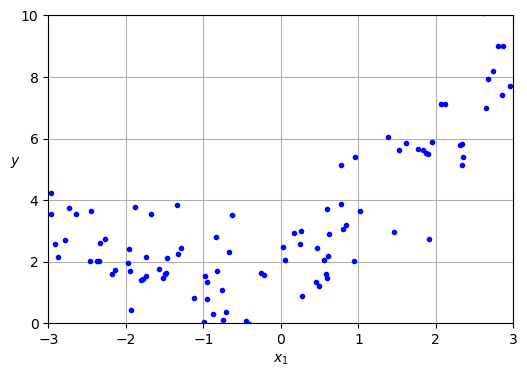

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")  # c="b", linstyle=”“， marker=”."   # b+""+"."
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)  # include_bias=False 不包括1

# PolynomialFeatures 特征可以转一下，转成一个带多项式的特征， degree=2表示最高到二次项
X_poly = poly_features.fit_transform(X)
X_poly.shape
X[0]
X_poly[0] # X_poly包含X的原始特征以及该特征的平方

In [29]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)  # 内部会默认算偏置的权重
lin_reg.intercept_, lin_reg.coef_

(array([1.84320636]), array([[0.95406518, 0.50130709]]))

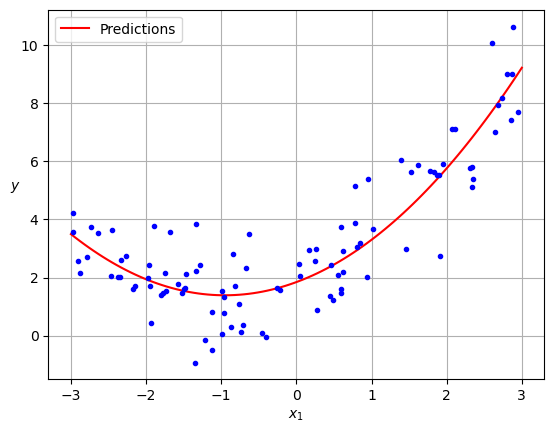

In [31]:
# 随堂练习，利用lin_reg的预测能力 和 poly_features的组合特征的能力，生成抛物线
x_test = np.linspace(-3,3,100)
y_pred = lin_reg.predict(poly_features.transform(x_test.reshape(-1, 1)))

plt.plot(x_test, y_pred, "r-", label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend()
plt.grid()
plt.show()

-注意：PolynomialFeatures可以将特征的所有组合添加到给定的多项式阶数。例如特征a和b，degree=3,会有ab，a^2 * b, ab^2. PolynomialFeatures(degree=d)可以将一个包含n个特征的数组转换为包含(n+d)!/(d!n!)个特征的数组, 要小心特征组合的数量爆炸


### 学习曲线
所有sklearn估计器都可以使用fit()方法进行训练，有一些估计器还有partial_fit()方法，可以调用该方法在一个或多个实例上运行单轮训练。

反复调用partial_fit()会逐渐训练模型。可能同时有一个warm_start=True的超参数，如果warm_start=True,则在训练模型调用fit()方法将不会重置模型，它会在停止的地方继续训练。

sklearn的学习曲线可以得到模型的训练误差和验证误差随训练集大小变化的图（类似于反复调用partial_fit(), 每次评估一次训练和验证误差），如果不支持partial_fit()或warm_start, 则必须在训练集逐渐变大的子集上多次训练它。

sklearn的learning_curve函数返回它评估模型的训练集大小，以及它为每个大小和每个交叉验证测量的训练和验证分数

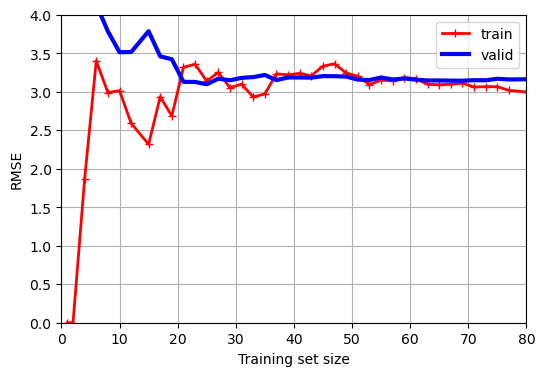

In [10]:
from sklearn.model_selection import learning_curve  # 导入学习曲线函数
from sklearn.linear_model import LinearRegression
train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5, scoring="neg_mean_squared_error")  # train_sizes 对应 40个 训练集的比例， 最小0.01， 最大1

# scoring="neg_mean_squared_error" 交叉验证希望分数越高越好，所以是 负的损失
train_sizes.shape
train_scores.shape  # 40 * 5, 因为有5次交叉验证
valid_scores.shape  # 40 * 5, 因为有5次交叉验证

train_errors = -train_scores.mean(axis=1)  # 40个不同训练集的评估结果， 去取平均数（平均5次验证）
valid_errors = -valid_scores.mean(axis=1)  #  # 40个不同训练集的评估结果， 去取平均数（平均5次验证）

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, c="r", linewidth=2, label="train", linestyle="-", marker="+")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 4])
plt.show()

这是个典型的欠拟合learning curve：训练集只有1-2个实例时，模型完全贴合，红色曲线从0开始，但是随着将新实例添加到训练集中，模型不能完美拟合数据，训练误差一致上升，直到达到平稳状态

验证误差：很多训练集时，无法正确泛化，一开始验证误差很大，随着样例变多，验证误差逐渐降低，但误差没降低多少已经趋于平稳，接近训练的误差曲线。

-> 典型的欠拟合状态：两条曲线趋于平稳，很接近，很高。

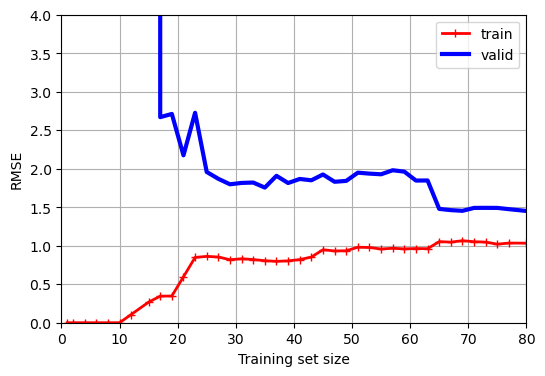

In [15]:
# 随堂练习：生成相同数据上10阶多项式模型的学习曲线（如下图） 提示：可以把Polynomial feature和LinearRegression组成一个流水线
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# X(只有一列/只有一个特征） -> [X, X^2, X^3, .... X^10]

a_pipeline = make_pipeline(PolynomialFeatures(10, include_bias=False), LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(a_pipeline, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5, scoring="neg_mean_squared_error")  # train_sizes 对应 40个 训练集的比例， 最小0.01， 最大1

train_errors = -train_scores.mean(axis=1)  # 40个不同训练集的评估结果， 去取平均数（平均5次验证）
valid_errors = -valid_scores.mean(axis=1)  #  # 40个不同训练集的评估结果， 去取平均数（平均5次验证）

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, c="r", linewidth=2, label="train", linestyle="-", marker="+")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 4])
plt.show()

这个学习曲线和之前的区别：
- 和之前比，训练数据上的误差要低得多
- 曲线之间存在间隙。这意味着该模型在训练数据上的性能要比在验证数据上的性能好得多，这是过拟合的标志。但是，如果使用更大的训练集，则两条曲线会继续接近

**理论：偏差/方差权衡**

- 偏差/方差权衡统计学和机器学习的重要理论成果是以下一个事实：模型的泛化误差可以表示为三个非常不同的误差之和： 偏差 + 方差 + 不可避免的误差 == 模型的预测误差
- 偏差：这部分泛化误差的原因在于错误的假设，比如假设数据是线性的，而实际上是二次的。高偏差模型最有可能对训练数据欠拟合。 （高偏差 是 欠拟合的另一个表达）
- 方差：这部分是由于模型对训练数据的细微变化过于敏感。具有许多自由度的模型（例如高阶多项式模型）可能具有较高的方差，因此可能过拟合训练数据。 （高方差 是 过拟合的另一个表达）
- 不可避免的误差：这部分误差是因为数据本身的噪声所致。减少这部分误差的唯一方法就是清洗数据（例如修复数据源（如损坏的传感器），或者检测并移除异常值）。

增加模型的复杂度通常会显著提升模型的方差，减少偏差。反过来，降低模型的复杂度则会提升模型的偏差，降低方差。这就是为什么称其为 方差-偏差权衡。

### 正则化线性模型
讨论的是通过约束模型的权重实现的正则化，岭回归（Ridge，L2正则化）， 套索回归（Lasso，L1正则化），弹性网络回归（Elastic Net，L1+L2正则化）

#### 岭回归

岭回归（L2正则化）是线性回归的正则化版本：将等于$\frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2$的正则化项添加到MSE。这迫使学习算法不仅拟合数据，而且还使模型权重尽可能地小。请注意，仅在训练期间将正则化项添加到代价函数中。训练模型后，你希望使用非正则化MSE（或RMSE）来评估模型的性能。

超参数α控制要对模型进行正则化的程度。如果α=0，则岭回归仅是线性回归。如果α非常大，则所有权重最终都非常接近于零，结果是一条经过数据均值的平线。
$$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2
$$

请注意，偏置项 $\theta_0$ 没有进行正则化（总和从 $i=1$ 开始，而不是 0）。
如果我们将 $\mathbf{w}$ 定义为特征权重的向量（$\theta_1$ 至 $\theta_n$），则正则项等于 $\alpha \|\mathbf{w}\|_2^2$，其中 $\|\mathbf{w}\|_2$ 表示权重向量的 $\ell_2$ 范数:   向量的l2范数算出来是个数字： 向量的分量的平方和开根号

对于梯度下降，只需将 $\frac{2\alpha}{m} \mathbf{w}$ 添加到 MSE 梯度向量中对应于特征权重的部分，而不添加任何偏差项的梯度。

在执行岭回归之前缩放数据（例如使用StandardScaler）很重要，因为它对输入特征的缩放敏感。大多数正则化模型都需要如此。

In [16]:
# alpha的增加会导致更平坦的预测，从而减少了模型的方差，但增加了其偏差
import numpy as np
np.random.seed(100)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [20]:
def foo(aaa , bbb):
    return aaa * bbb

foo(aaa=3, bbb=5)
foo(**{"aaa":3, "bbb":5})  # 这一行的代码 和 上一行的效果 foo(aaa=3, bbb=5)

15

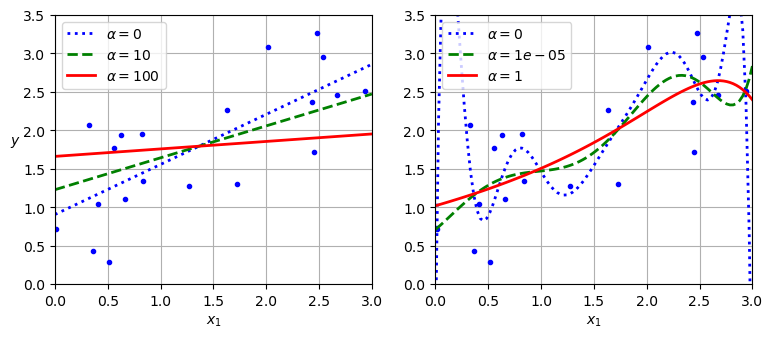

In [45]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 线性回归要正则化的话

from sklearn.linear_model import Ridge

X_new = np.linspace(0, 3, 100).reshape(100, 1)
def plot_model(model_class, polynomial, alphas, **model_kwargs):
    # model_class: 某一个模型类（有fit方法的估计器）
    # polynomial：布尔值，True用多项式模型，False直接线性模型
    # alphas：小数列表，里面的每个数，都代表一个正则化的强度
    # **model_kwargs: model_kwargs本身字典， **字典放到函数里调用，等于会把 字典的键和值摊开，当成关键字参数
    #                 模型本身的超参数

    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            # 如果alpha > 0, 这里的model_class就是 Ridge， 然后就是  实例化 不同 正则化强度alpha的 岭回归
            model = model_class(alpha=alpha, **model_kwargs)
        else:
            model = LinearRegression()

        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y.ravel())
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)   # plt.subplot(121), 1行2列的第一张图
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=100)
plt.ylabel("$y$  ", rotation=0)


plt.subplot(122)   # plt.subplot(122), 1行2列的第二张图
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=100)
plt.show()

alpha增加会导致更平坦的预测，从而减少了模型的方差，但增加了其偏差。

岭回归可以通过计算闭合形式的方程 或执行梯度下降执行， 闭式解公式：$
\hat{\boldsymbol{\theta}} = (X^\top X + \alpha A)^{-1} X^\top \mathbf{y}
$


In [46]:
# 岭回归可以通过计算闭合形式的方程 或执行梯度下降执行
from sklearn.linear_model import SGDRegressor

# 通过Ridge类 （Ridege估计器）去训练 正则化的回归模型
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.1, solver="cholesky")  # solver="cholesky" 闭式解公式的变体
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])


# 通过随机梯度下降，去训练正则化的回归模型
# penalty="l2", alpha=0.1/m -> 添加正则项 alpha * l2范数的平方，这里 0.1/m，/m要手动添加，获得和Ridge(alpha=0.1)一样的效果
#  tol=None表示不会提前停止，跑到max_iter规定的次数
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1/m, tol=None, max_iter=1000, eta0=0.1, random_state=100)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.88777645])

RidgeCV类也执行岭回归，但它使用交叉验证自动调整超参数。它大致相当于使用GridSearchCV，但它针对岭回归进行了优化并且运行速度更快。其他几个估计器（主要是线性的）也有高效的CV变体，例如LassoCV和ElasticNetCV。

#### Lasso回归
它和岭回归类似，在代价函数上增加了一个正则化项，但它使用向量的l1范数而不是l2范数的平方，注意l1范数乘以2a，而l2范数在岭回归中乘以a/m。不同的范数选择不同系数的目的是确保选择最佳的a可以独立于训练集大小

为什么l2正则化的 正则化强度/m，但是l1正则化的 正则化强度 不用除以m？

为了一个目的：我在选择alpha的时候，可以不考虑m （训练集的大小）

向量的l1范数：数字 == 向量分量的绝对值的（1次方）的和

$$
J(\theta)=\text{MSE}(\theta)+2\alpha\sum_{i=1}^{n}\lvert\theta_i\rvert
$$


- Lasso回归和岭回归的相似性：都可以限制权重大小，进而降低过拟合 （直接记）

$$
w^{(t+1)} \;=\; w^{(t)} \;-\; \eta\,\alpha\,\operatorname{sign}\!\bigl(w^{(t)}\bigr)
$$

其中
$
\operatorname{sign}(w_t)=
\begin{cases}
-1, & w_t < 0\\
[-1,1], & w_t = 0\\
+1, & w_t > 0
\end{cases}
$

上述公式省掉了 均方误差函数的梯度，重点体现权重的衰减： W是正数，微小幅度往下降；W是负数，微小幅度往上升；W是0，可以保持不变

Lasso代价函数在权重为0处是不可微(不可导）的，但是用任何围绕该点的梯度值之间的中间值去替代，梯度下降仍然可以正常工作


- Lasso回归和岭回归的不同：岭回归倾向把权重压得接近0，Lasso回归倾向于完全消除掉不重要特征得权重。换句话说，Lasso回归自动执行特征选择并输出具有很少非零特征权重的系数模型 （直接记）

解释：L1正则化的损失函数的梯度 = 0 在权重是0的时候更容易被满足

数学细节（了解）：



1. 设定

记

* 训练样本 $X\in\mathbb R^{n\times p}$，目标 $y\in\mathbb R^{n}$
* 参数向量 $w\in\mathbb R^{p}$

目标函数（把 $1/2n$ 写进平方误差，只为符号简洁）

$$
J(w)
= \frac1{2n}\,\|\,y-Xw\|_2^{2} \;+\; \lambda\,\|w\|_1
\tag{1}
$$

其中 $\lambda>0$ 控制正则强度。



2. 可微部分的梯度

平方损失是可微的：

$$
\nabla_{w}\frac1{2n}\,\|\,y-Xw\|_2^{2}
= -\frac1n X^{\!\top}(y-Xw)
=: g(w)\in\mathbb R^{p}.
\tag{2}
$$

（也常写成 $g(w)=\frac1n X^{\!\top}Xw-\frac1n X^{\!\top}y$。）



3. 不可微部分的**次梯度**

L1 范数在 $w_j=0$ 处不可导，用**次梯度 (sub-gradient)**：

$$
\partial|w_j|=
\begin{cases}
\{\;+\!1\;\}, & w_j>0 \\[2pt]
[-1,+1], & w_j=0 \\[2pt]
\{\;-1\;\}, & w_j<0
\end{cases}
\tag{3}
$$

整体写成向量形式：$\partial\|w\|_1 = \{\,s\in\mathbb R^{p} \mid s_j\in\partial|w_j|\,\}$.



4. 最优条件：**0 = 梯度 + λ·次梯度**

$$
\mathbf 0 \;\in\;
g(w) \;+\; \lambda\,\partial\|w\|_1
\tag{4}
$$

把它拆成每一维 $j$：

$$
0\;\in\;g_j(w) + \lambda\cdot \mathrm{sign}(w)_j,
\qquad
\text{其中 } \mathrm{sign}(0)\equiv[-1,1].
\tag{5}
$$



5. 逐坐标解析：产生“0”与“软阈值”

设残差 $r = y - Xw$。由 (2):

$$
g_j(w) \;=\; -\frac1n \boldsymbol x_j^{\!\top} r
$$

其中 $\boldsymbol x_j$ 是第 $j$ 列特征向量。



5.1 若 $w_j\neq0$

则 $\mathrm{sign}(w_j)$ 只可能是 ±1，(5) 变为

$$
-\frac1n\boldsymbol x_j^{\!\top}r + \lambda\,\mathrm{sign}(w_j)
 = 0
\;\;\Longrightarrow\;\;
\bigl|\boldsymbol x_j^{\!\top}r\bigr|/n = \lambda .
\tag{6}
$$

也就是说 **非零权重必须让该特征与残差的相关度** 精准等于 $\lambda$。



5.2 若 $w_j=0$

此时 $\mathrm{sign}(0)=[-1,1]$，条件 (5) 允许

$$
\left|\,\frac1n \boldsymbol x_j^{\!\top} r \right|
\;\le\;\lambda .
\tag{7}
$$

> ↳ **宽松得多**：只要相关度落进 $[-λ,λ]$，就满足最优条件，
> 所以“停在 0”最容易。





In [47]:
from sklearn.linear_model import Lasso  # Lasso: L1正则化的线性回归类

lasso_reg = Lasso(alpha=0.1)  # L1正则化的线性回归实例，正则化强度是0.1
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.86696274])

In [56]:
# 随堂练习：注意上述可以改用 SGDRegressor(penalty="l1", alpha=0.1)
sgd_l1_reg = SGDRegressor(penalty="l1", alpha=0.2, max_iter=10000, tol=None, random_state=100, eta0=0.2)
sgd_l1_reg.fit(X,y.ravel())
sgd_l1_reg.predict([[1.5]])

# plt.figure(figsize=(9, 3.5))
# plt.subplot(1,2,1)
# plot_model(SGDRegressor, polynomial=False, alphas=(0, 0.2, 2), random_state=100, penalty="l1")
# plt.ylabel("$y$  ", rotation=0)
# plt.subplot(1,2,2)
# plot_model(SGDRegressor, polynomial=True, alphas=(0, 2e-2, 2), random_state=100, penalty="l1")   # a=0.01时 已经看起来像个二次曲线了，体现Lasso回归自动特征选择，并输出很少非0特征权重
# plt.show()


array([1.86521398])

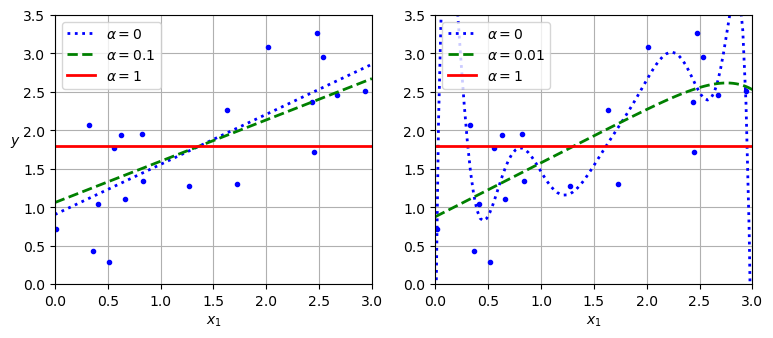

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 3.5))
plt.subplot(1,2,1)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=100)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(1,2,2)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=100)   # a=0.01时 已经看起来像个二次曲线了，体现Lasso回归自动特征选择，并输出很少非0特征权重
plt.show()

为了防止在使用Lasso时梯度下降最终在最优解附近反弹，需要降低训练期间的学习率，虽然降低仍会反弹，但反弹幅度不大，学习率 乘以 梯度会越来越小，最终收敛

#### 弹性网络回归
弹性网络回归是岭回归和Lasso回归之间的中间地带。它的正则化项是岭和Lasso正则化项的加权和。可以控制混合比r，当r=0时，弹性网络相当于岭回归，当r=1时，相当于Lasso回归
$$J(\boldsymbol{\theta}) \;=\; \mathrm{MSE}(\boldsymbol{\theta}) \;+\; r\!\bigl(2\alpha \sum_{i=1}^{n} \lvert \theta_i \rvert \bigr) \;+\; (1-r)\!\left(\frac{\alpha}{m}\sum_{i=1}^{n} \theta_i^{2}\right)$$


什么时候应该使用弹性网络、岭、Lasso，或者普通的线性回归（即不进行任何正则化）呢？(记忆)

通常来说，有正则化（哪怕是很小），总是比没有更可取一些。所以大多数情况下，应该避免使用纯线性回归。岭回归是个不错的默认选择，但是如果你觉得实际用到的特征只有少数几个，那就应该更倾向于Lasso回归或是弹性网络，因为它们会将无用特征的权重降为零，如前所述。一般而言，弹性网络优于Lasso回归，因为当特征数量超过训练实例数量，又或者是几个特征强相关时，Lasso回归的表现可能非常不稳定。

In [57]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV   # 这些正则化回归，它们有自己的 交叉验证，找最优超参数的方式

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.1)  # alpha=0.1对应公式里的 α, l1_ratio对应公式里的r
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.87283437])

### 早停
对于梯度下降这一类迭代学习的算法，还有一个与众不同的正则化方法，就是在验证误差达到最小值时停止训练，该方法叫作早停法。下图展示了一个用批量梯度下降训练的复杂模型（高阶多项式回归模型），该模型正在我们之前使用的二次数据集上使用批量梯度下降进行训练。经过一轮一轮的训练，算法不断地学习，训练集上的预测误差(RMSE)自然不断下降，其在验证集上的预测误差也随之下降。但是，一段时间之后，验证误差停止下降反而开始回升。这说明模型开始过拟合训练数据。通过早停法，一旦验证误差达到最小值就立刻停止训练。这是一个非常简单而有效的正则化技巧

下面首先添加多项式特征并缩放所有输入特征，包括训练集和验证集（代码假定你已将原始训练集拆分为较小的训练集和验证集）。然后它创建一个没有正则化和小学习率的SGDRegressor模型。在训练循环中，它调用partial_fit()而不是fit()来执行增量学习。在每个轮次中，它测量验证集上的RMSE。如果它低于目前看到的最低RMSE，它会在best_model变量中保存模型的副本。此实现实际上并没有停止训练，但它可以在训练后恢复到最佳模型。注意，模型是使用copy.deepcopy()复制的，因为它同时复制了模型的超参数和学习到的参数（模型内部的属性）。相反，sklearn.base.clone()只复制模型的超参数。

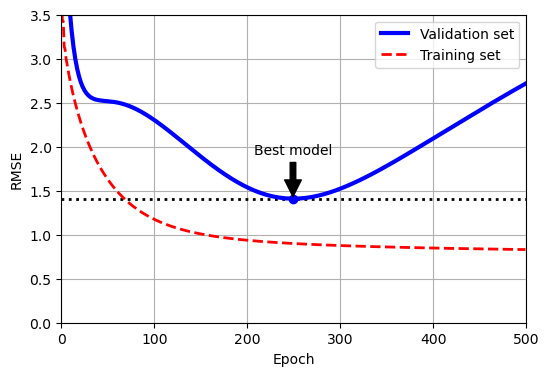

In [1]:
import numpy as np
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)


sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500


best_valid_rmse = float('inf')  # 现在开始训练之前，全局最优的 验证集误差，应该设置成 正无穷大，后面比较才可能替换掉这个值

train_errors, val_errors = [], []  # 训练误差 和 验证误差

for epoch in range(n_epochs):

    sgd_reg.partial_fit(X_train_prep, y_train)

    y_valid_predict = sgd_reg.predict(X_valid_prep)  # 得到在验证集上的预测值
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)  # 评估在验证集上的误差

    # 早停的核心逻辑
    if val_error <  best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)  # 通过深拷贝，当前的 sgd_reg,保存最优模型

    # 每个轮次计算训练误差 和 验证误差
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)


best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))

# 在图里 画文本+箭头
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",   # 水平方向对齐方式
             arrowprops=dict(facecolor='black', shrink=0.05))   # arrowprops 字典中的一个键，用来设置箭头两端的“收缩比例”，即让箭头稍微不完全连接起点 xy 和终点 xytext

plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)  # 横线: 在最佳验证误差的地方 做了个切线
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")                 # 验证误差折线
plt.plot(best_epoch, best_valid_rmse, "bo")                                     # 最佳验证误差的点
plt.plot(train_errors, "r--", linewidth=2, label="Training set")                # 训练误差折线
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
plt.show()

In [6]:
# validation_fraction=0.1：会自动将训练数据中划出 10% 作为验证集。
# 在每一次迭代（或每一轮 boosting）之后，模型会用验证集评估指标（比如 均方误差）。
# 如果连续 n_iter_no_change 次迭代，验证集上指标没有显著提升（由 tol 决定），就会触发提前停止。

# 随堂练习：早停策略用sklearn实现， 关注超参数SGDRegressor的超参数：
# early_stopping（布尔值，是否要早停）,validation_fraction（数字，验证集的比例）, n_iter_no_change(正数）,

# sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42, validation_fraction=0.5, early_stopping=True, tol=1e-5, n_iter_no_change=10, max_iter=10000)

sgd_reg = SGDRegressor(penalty=None, eta0=0.002, max_iter=100000, tol=None)
sgd_reg.fit(X, y.ravel())
sgd_reg.n_iter_   #   通过 n_iter_属性 ，知道实际进行了多个轮次的训练

100000

### 逻辑回归

逻辑回归的前提：假设实例的特征 围绕其所属类的均值 服从高斯分布；最小化损失函数是在最大化 实例特征在自己类的出现概率

应用在鸢尾花数据集：一个非常著名的数据集，共有150朵鸢尾花，分别来自三个不同品种：Setosa鸢尾花、Versicolor鸢尾花和Virginica鸢尾花，数据里包含花的萼片以及花瓣的长度和宽度

下面示例仅根据花瓣宽度特征来检测Virginica鸢尾花类型

In [15]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
type(iris) # sklearn.utils._bunch.Bunch, 可以看成字典，（变量名.键， 去读取键对应的值）
list(iris)
iris.data.head(3)
iris.target
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'  # 0/1二元分类

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
log_reg = LogisticRegression(random_state=42)  # 也可以用l1/l2正则化， C控制正则化强度，值越高，正则化越少
log_reg.fit(X_train, y_train)

print(log_reg.coef_)

[[3.83637715]]


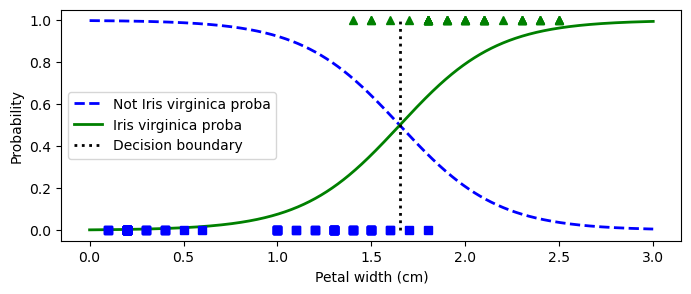

In [40]:
#  exp(w*x+b)

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)  # 逻辑回归最后预测出来是概率，所以逻辑回归内部 predict_proba
decision_boundary = X_new[y_proba[:,1] >= 0.5][0,0]  # 决策边界是一个维度的， 就是一个数字  （因为只有一个特征0

plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")
#
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")   # marker="s"  方形
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")   # marker="^"  三角形
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")

plt.legend(loc="center left")
plt.show()

Virginica鸢尾花（三角形所示）的花瓣宽度范围为1.4～2.5cm，而其他两种鸢尾花（正方形所示）花瓣通常较窄，花瓣宽度范围为0.1～1.8cm。注意，这里有一部分重叠。对花瓣宽度超过2cm的花，分类器可以很有信心地说它是一朵Virginica鸢尾花（对该类别输出一个高概率值），对花瓣宽度低于1cm以下的，也很有信心地说其不是（对“非Virginica鸢尾花”类别输出一个高概率值）。在这两个极端之间，分类器则不太有把握。但是，如果你要求它预测出类［使用predict()方法而不是predict_proba()方法］，它将返回一个可能性最大的类别。也就是说，在大约1.6cm处存在一个决策边界，这里“是”和“不是”的可能性都是50%，如果花瓣宽度大于1.6cm，分类器就预测它是Virginica鸢尾花

In [26]:
decision_boundary
log_reg.predict([[1.7], [1.5]])

array([ True, False])

- 与其他线性模型一样，逻辑回归模型可以用l1或l2惩罚函数来正则化，sklearn默认添加的是l2函数
- 逻辑回归模型的正则化强度超参数不是alpha，而是C， C可以看成alpha的倒数：C值越高，对模型的正则化越少

### softmax回归
逻辑回归模型经过推广，可以直接支持多个类，而不需要训练并组合多个二元分类器。这就是softmax回归，或者叫多元逻辑回归。

原理很简单：给定一个实例x，softmax回归模型首先计算出每个类k的分数$s_k(x)$，然后对这些分数应用softmax函数（也叫归一化指数），估算出每个类的概率，分数本身看起来跟线性回归预测的方程类似。


$$ S_k(x) = (\theta^{(k)})^\top x \$$

请注意，每个类都有自己的特定参数向量 $ \theta^{(k)}\ $。所有这些向量通常都作为行存储在参数矩阵 $\Theta\$ 中。

一旦为实例 $x$ 计算了每个类的分数，就可以通过 softmax 函数来估计实例属于类的概率 $\hat{p}_k\$。该函数计算每个分数的指数，然后对其进行归一化（除以所有指数的总和）。

**公式 ：softmax 函数**

$$
\hat{p}_k=\sigma\!\big(s(x)\big)_k
= \frac{\exp\!\big(s_k(x)\big)}
{\sum_{j=1}^{K}\exp\!\big(s_j(x)\big)}
$$

在此等式中：

- $k$ 是类别数目。
- s(x) 是一个向量，其中包含实例 x 的每个类的分数。
- $\sigma\\big(s(x)\big)_k\$ 是给定该实例每个类的分数，实例 x 属于第 k 类的估计概率，。

就像逻辑回归分类器一样，softmax回归分类器预测具有最高估计概率的类（简单来说就是分数最高的类):

$$
\hat{y}
= \arg\max_{k}\ \sigma\!\big(s(x)\big)_k
= \arg\max_{k}\ s_k(x)
= \arg\max_{k}\ \big(\theta^{(k)}\big)^{\top} x
$$

argmax运算符返回使函数最大化的变量值，在此等式中，它返回使得估计概率最大化的分类值（k值）

注意：softmax回归分类器一次只能预测一个类（它是多类，而不是多输出），因此它只能与互斥的类（例如不同种类的植物）一起使用。无法使用它做多输出（比如在一张照片中识别多个人）


- softmax如何训练：

训练目标是得到一个能对目标类做出高概率估算的模型（也就是其他类的概率相应要很低）。通过将代价函数（也叫作交叉熵）最小化来实现这个目标，因为当模型对目标类做出较低概率的估算时，会受到惩罚。交叉熵经常被用于衡量一组估算出的类概率与目标类的匹配程度。

$$
J(\Theta)= -\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K} y_{k}^{(i)} \,\log\!\left(\hat{p}_{k}^{(i)}\right)
$$

在此等式中：$y_k^{(i)}$ 是属于第 $k$ 类的第 $i$ 个实例的目标概率，等于 $1$ 或 $0$，具体取决于该实例是否属于该类。

请注意，当只有两个类（$K=2$）时，此代价函数等效于逻辑回归的代价函数。

类k的交叉熵梯度向量：

$$
\nabla_{\theta^{(k)}} J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} \left( \hat{p}_k^{(i)} - y_k^{(i)} \right) \mathbf{x}^{(i)}
$$

通过上面计算的梯度，找到最小化函数的参数矩阵



In [45]:
# 应用LogisticRegression分类器对两个以上的类进行训练，会自动使用softmax回归，
# 默认使用l2正则化，可以用超参数C控制正则化强度 （C=1/系数)

X = iris.data[["petal width (cm)", "petal length (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)


LogisticRegression(C=30, random_state=42)

In [52]:
# softmax_reg.predict([[2,2]])

# softmax_reg.predict_proba([[2,2]]).round(2)  # 三个值 （代表3个类的概率）
softmax_reg.predict([[2,2]])  # 一个值 （代表最后的分类结果）

# 随堂softmax_reg最后预测正确 （accuracy，精度）的概率是多少

# 1. softmax_reg.predict_proba() 算三个概率  算的 测试集的概率
test_probs = softmax_reg.predict_proba(X_test)  # 形状： 测试的数量 * 3
test_probs.shape

# 2. 取概率最大对应的分类: 38*3， 看每一行最大值 出现的索引是什么
test_pred = np.argmax(test_probs, axis=1)


# 3. 看预测的分类 和真实分类对比，得出 在测试集 预测的精度
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_pred)  # 100%的准确率
np.all(y_test == test_pred)

True